## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

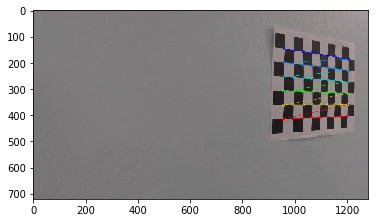

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

### Test undistorted correction

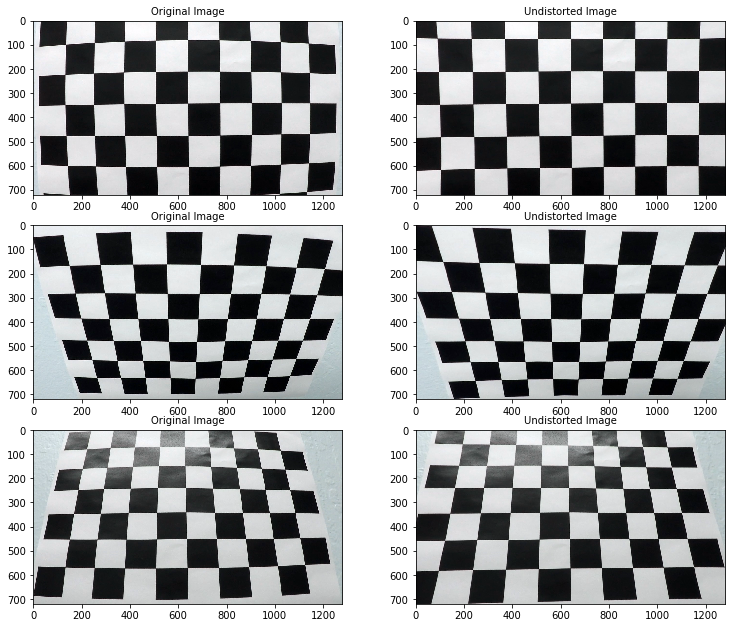

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    #undist = np.copy(img)  # Delete this line
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img1 = cv2.imread('camera_cal/calibration1.jpg')
undistorted1 = cal_undistort(img1, objpoints, imgpoints)
img2 = cv2.imread('camera_cal/calibration2.jpg')
undistorted2 = cal_undistort(img2, objpoints, imgpoints)
img3 = cv2.imread('camera_cal/calibration3.jpg')
undistorted3 = cal_undistort(img3, objpoints, imgpoints)

f, ax = plt.subplots(3, 2, figsize=(10, 9))
f.tight_layout()
ax[0,0].imshow(img1)
ax[0,0].set_title('Original Image', fontsize=10)

ax[0,1].imshow(undistorted1)
ax[0,1].set_title('Undistorted Image', fontsize=10)

ax[1,0].imshow(img2)
ax[1,0].set_title('Original Image', fontsize=10)

ax[1,1].imshow(undistorted2)
ax[1,1].set_title('Undistorted Image', fontsize=10)

ax[2,0].imshow(img3)
ax[2,0].set_title('Original Image', fontsize=10)

ax[2,1].imshow(undistorted3)
ax[2,1].set_title('Undistorted Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

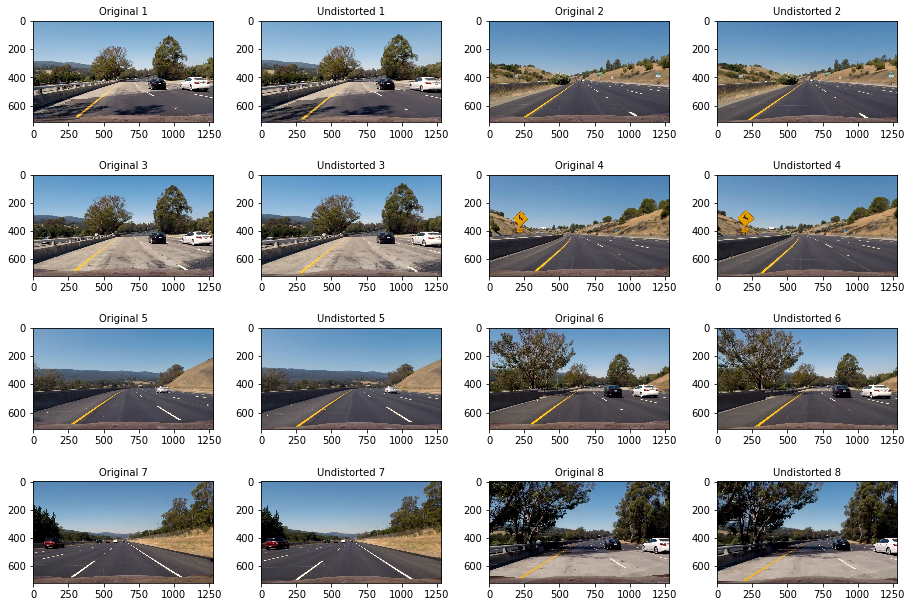

In [4]:
test_images = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(4, 4, figsize=(12, 9));
f.tight_layout()

images = []
undistorted_images = []
ax1, ax2 = 0, 0
count = 1
for fname in test_images:
    img = cv2.cvtColor( cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    images.append(img)
    
    ax[ax1, ax2].imshow( img )
    ax[ax1, ax2].set_title('Original {}'.format(count), fontsize=10)
    
    ax2+=1
    
    undist = cal_undistort(img, objpoints, imgpoints)
    undistorted_images.append( undist )
    ax[ax1, ax2].imshow( undist )
    ax[ax1, ax2].set_title('Undistorted {}'.format(count), fontsize=10)
    
    if ax2==3:
        ax2=0
        ax1+=1
    else:
        ax2+=1
    count += 1

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.);

### Use color transforms, gradients, etc., to create a thresholded binary image.

#### Gradient treeshold

In [5]:
# Sobel Functions 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255) ):
    # Apply the following steps to img
    # 1) Receive 1chanel img    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary#np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelX**2 + sobelY**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelMag/np.max(sobelMag))
    
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelX = np.absolute(sobelX)
    abs_sobelY = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobelY, abs_sobelX)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(dir)
    sxbinary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

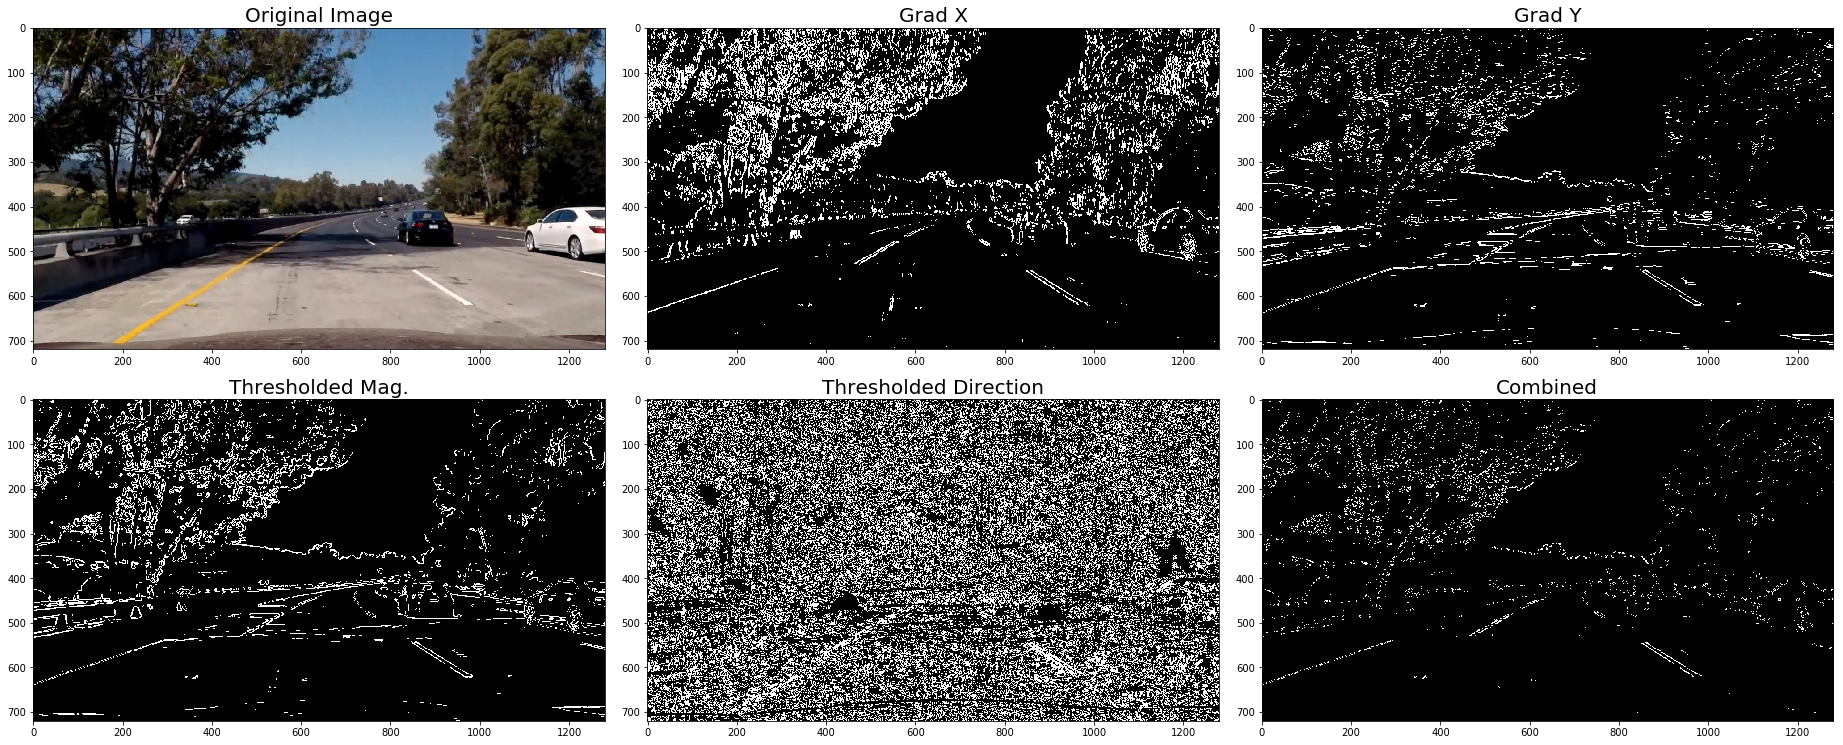

In [6]:
image = undistorted_images[7]

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions

sobel_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
sobel_img = sobel_img[:,:,2]

gradx = abs_sobel_thresh(sobel_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(sobel_gray, orient='y', sobel_kernel=ksize, thresh=(40,90))
mag_binary = mag_thresh(sobel_gray, sobel_kernel=ksize, mag_thresh=(45, 100))
dir_binary = dir_threshold(sobel_gray, sobel_kernel=ksize, thresh=(.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axarr = plt.subplots(2, 3, figsize=(25, 11))
f.tight_layout()

axarr[0,0].imshow(image)
axarr[0,0].set_title('Original Image', fontsize=20)

axarr[0,1].imshow(gradx, cmap='gray')
axarr[0,1].set_title('Grad X', fontsize=20)

axarr[0,2].imshow(grady, cmap='gray')
axarr[0,2].set_title('Grad Y', fontsize=20)

axarr[1,0].imshow(mag_binary, cmap='gray')
axarr[1,0].set_title('Thresholded Mag.', fontsize=20)

axarr[1,1].imshow(dir_binary, cmap='gray')
axarr[1,1].set_title('Thresholded Direction', fontsize=20)

axarr[1,2].imshow(combined, cmap='gray')
axarr[1,2].set_title('Combined', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Color Treeshold

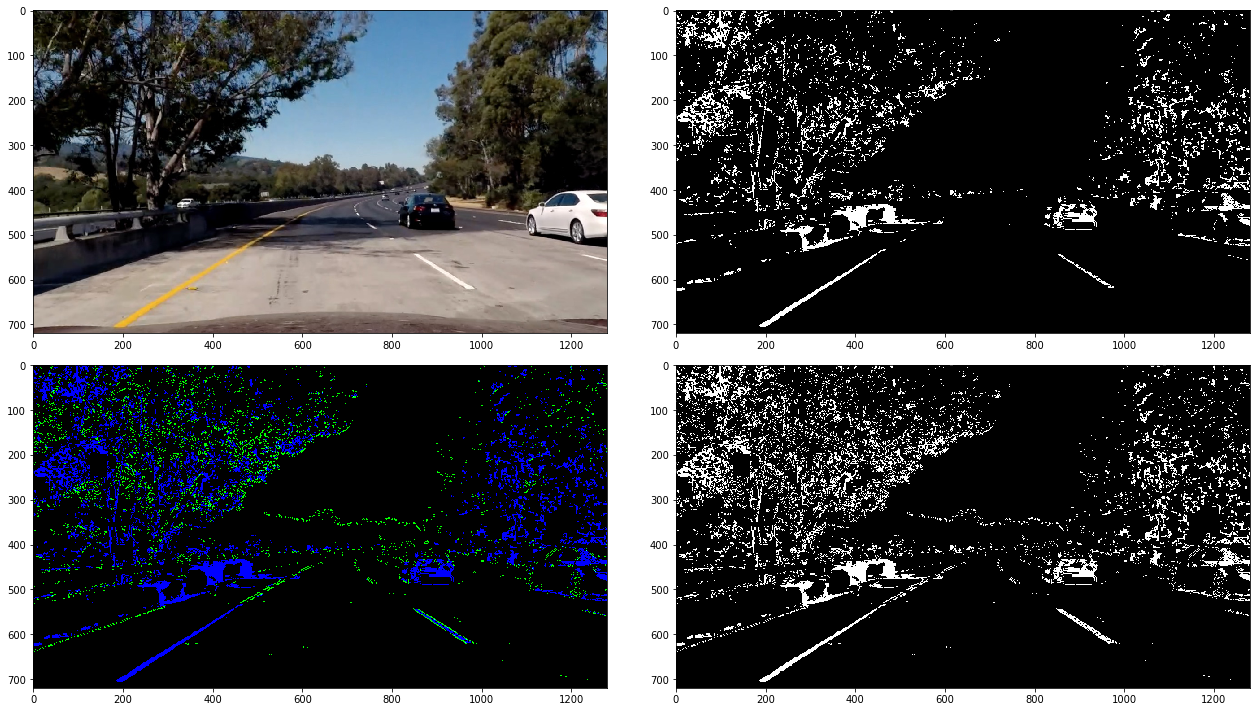

In [7]:
s_thresh=(180, 255)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS);
h_image = hls[:,:,0];
l_image = hls[:,:,1];
s_image = hls[:,:,2];

s_binary = np.zeros_like(s_image)
s_binary[(s_image>=s_thresh[0])&(s_image<=s_thresh[1])] = 1

color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))

color_grad_thresh = np.zeros_like(combined)
color_grad_thresh[(combined==1)|(s_binary==1)] = 1 

f, ax = plt.subplots(2, 2, figsize=(18, 10));
f.tight_layout()
ax[0,0].imshow(image);
ax[0,1].imshow(s_binary, cmap='gray');
ax[1,0].imshow(color_binary);
ax[1,1].imshow(color_grad_thresh, cmap='gray');

In [8]:
def threshold(img):
    # Gradient Treshold
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Color Treshold
    s_thresh=(180, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS);
    s_image = hls[:,:,2];

    s_binary = np.zeros_like(s_image)
    s_binary[(s_image>=s_thresh[0])&(s_image<=s_thresh[1])] = 1

    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))

    #Combine color and gradient threshold
    color_grad_thresh = np.zeros_like(combined)
    color_grad_thresh[(combined==1)|(s_binary==1)] = 1 
    
    return color_grad_thresh

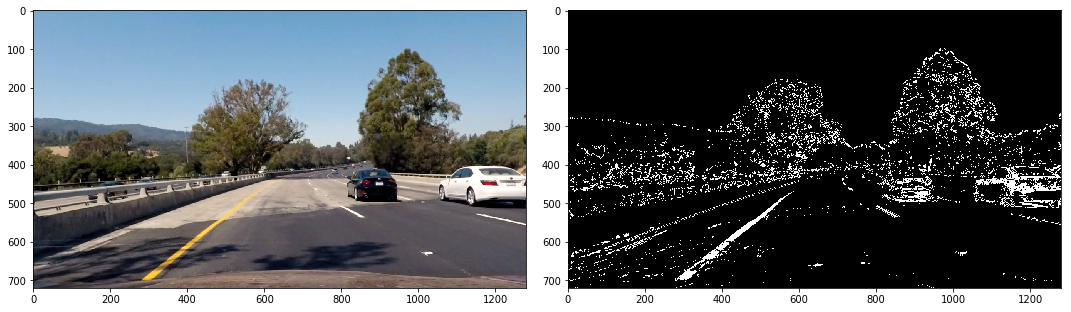

In [9]:
# Test tresholding
img = undistorted_images[0]
thresholded = threshold(img)

f, ax = plt.subplots(1, 2, figsize=(15, 5));
f.tight_layout()

ax[0].imshow( img );
ax[1].imshow( thresholded, cmap='gray' );

#### Perspective Transform

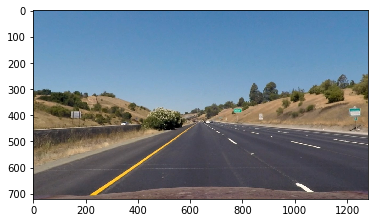

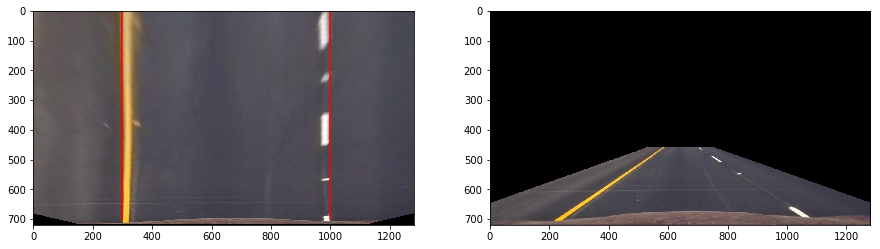

In [10]:
src = np.float32(
    [[705, 460],
     [1057, 680],
     [250, 680],
     [579, 460]])

dst = np.float32(
    [[1000, 0],
     [1000, 700],
     [300, 700],
     [300, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    
def warp(img, inverse=False):
    img_size = (img.shape[1], img.shape[0])
    
    if inverse:
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped

img = undistorted_images[1]

warped = warp(img)
unwarped = warp(warped, True)

plt.imshow( img )

f, ax = plt.subplots(1, 2, figsize=(15, 5));
ax[0].imshow( warped );
ax[0].plot([1000, 1000],[0,700], 'r-');
ax[0].plot([300, 300],[0,700], 'r-');

ax[1].imshow( unwarped );

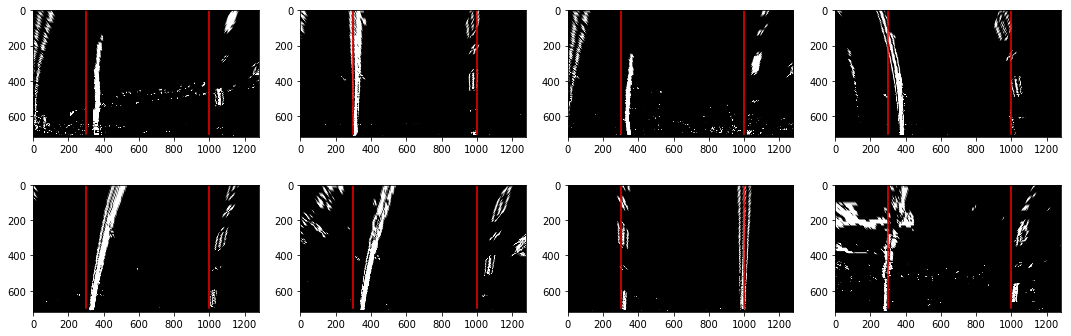

In [11]:
warped_images = []

f, ax = plt.subplots(2, 4, figsize=(15, 5));
f.tight_layout()

row, col = 0, 0
for img in undistorted_images:
    warped = warp(threshold(img))
    warped_images.append(warped)
    ax[row,col].imshow( warped, cmap="gray" );
    ax[row,col].plot([1000, 1000],[0,700], 'r-');
    ax[row,col].plot([300, 300],[0,700], 'r-');
       
    col+=1
    if col==4:
        col=0
        row+=1

#### Detect the lines

In [12]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Color each side
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Draw Line
# Generate x and y values for plotting
#ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)
cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

NameError: name 'binary_warped' is not defined

In [ ]:
binary_warped = warped_images[5]
#left_fit, right_fit, out_img = detect_lines(binary_warped)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

pts = np.array(list(zip(left_fitx, ploty)), np.int32)
cv2.polylines(out_img,[pts],False,(0,255,255), 2, lineType=cv2.CV_AA)

pts2 = np.array(list(zip(right_fitx, ploty)), np.int32)
cv2.polylines(out_img,[pts2],False,(0,255,255), 2, lineType=8)

plt.imshow(out_img.astype(np.uint8));

plt.plot(left_fitx, ploty, color='yellow');
plt.plot(right_fitx, ploty, color='yellow');
plt.xlim(0, 1280);
plt.ylim(720, 0);

#### Skip Sliding winow if known

In [ ]:
binary_warped = warped_images[5]
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result.astype(np.uint8))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Detect Line (sliding window if no previous line)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        # values for detected left line pixels
        self.leftx = None
        self.lefty = None
        
        # values for detected right line pixels
        self.rightx = None
        self.righty = None
        
def sliding_windows(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Save line objects
    line_left.detected = True
    line_right.detected = True
    
    line_left.leftx = leftx
    line_left.lefty = lefty
    line_right.rightx = rightx
    line_right.righty = righty
    
    line_left.current_fit = left_fit
    line_right.current_fit = right_fit

    
def line_margin(binary_warped):
    left_fit = line_left.current_fit
    right_fit = line_right.current_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Save line objects
    line_left.detected = True
    line_right.detected = True
    
    line_left.leftx = leftx
    line_left.lefty = lefty
    line_right.rightx = rightx
    line_right.righty = righty
    
    line_left.current_fit = left_fit
    line_right.current_fit = right_fit
    

In [ ]:
   
def detect_lines(binary_warped):
    """Detect lines using either sliding windows or a margin near line"""
    if not line_left.detected:
        # Detect lines with sliding windows
        sliding_windows(binary_warped)        
    else:
        # Line margin
        line_margin(binary_warped)


line_left, line_right = Line(), Line()
binary_warped = warped_images[5]
detect_lines( binary_warped );

In [ ]:
detect_lines( binary_warped )

#### Measuring Curvature

In [ ]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Pixel space:", left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print("Real World:", left_curverad, 'm', right_curverad, 'm')

#### Draw in original image

In [ ]:
original = undistorted_images[5]
warped = warped_images[5]

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Video Pipeline

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [ ]:
def process_image(image):
    # Undistort Image
    image = cal_undistort(image, objpoints, imgpoints)
    # Binary Threshold
    binary = threshold(image)
    # Perspective transform
    warped = warp(binary)
    
    # Detect Lane Line
    detect_lines(warped)
    
    left_fit = line_left.current_fit
    right_fit = line_right.current_fit
    
    # Fit lines in plot
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result = np.dstack((warped, warped, warped))*255
    
    # Color in left and right line pixels
    result[line_left.lefty, line_left.leftx] = [255, 0, 0]
    result[line_right.righty, line_right.rightx] = [0, 0, 255]
        
    # Draw Lines
    pts = np.array(list(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(result,[pts],False,(255,255,255), thickness=2)
    pts2 = np.array(list(zip(right_fitx, ploty)), np.int32)
    cv2.polylines(result,[pts2],False,(255,255,255), thickness=2)
    
    '''
    # Meassure Curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, True) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Place text on image
    # Now our radius of curvature is in meters
    txt = "Curve: left {0:.2f}m, right {0:.2f}m".format(left_curverad, right_curverad)
    cv2.putText(result, txt, (100,100), cv2.FONT_HERSHEY_PLAIN, 1.8, (255,255,255), 2)'''
    
    return result.astype( np.uint8 )

line_left, line_right = Line(), Line()
plt.figure(figsize=(10,10))
plt.imshow( process_image(images[1]) );

plt.figure(figsize=(10,10))
plt.imshow( process_image(images[3]) );

##### Clip 1

In [ ]:
clip1 = "project_video.mp4"
clip1_output = 'output_video/project_annotated.mp4'

line_left, line_right = Line(), Line()

video = VideoFileClip(clip1).subclip(5,6)
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(clip1_output, audio=False)

In [ ]:
video = io.open(clip1_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

##### Clip 2 Challenge Video  

In [ ]:
clip2 = "challenge_video.mp4"
clip2_output = 'output_video/challenge_annotated.mp4'

video = VideoFileClip(clip2).subclip(0,.1)
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(clip2_output, audio=False)

In [ ]:
video = io.open(clip2_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

##### Clip 3 Harder Challenge Video

In [ ]:
clip3 = "harder_challenge_video.mp4"
clip3_output = 'output_video/harder_challenge_annotated.mp4'

video = VideoFileClip(clip3).subclip(0,.1)
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(clip3_output, audio=False)

In [ ]:
video = io.open(clip3_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

In [ ]:
test = []

test.append([1])
test.append([2])
test.append([3])
test.append([4])

print( test)
print( np.concatenate(test))